<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/abs_mortalidade_incidencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import io
import gzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
cols = "place_type","city_ibge_code", "date","last_available_death_rate", "dt"
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, parse_dates=["date"], dtype={"city_ibge_code": str})
covid = covid.loc[(covid['place_type'].eq('city') & covid['date'].eq('2021-02-21'))]

In [ ]:
username = 'mirianbatista'
token = '2e37c8d3f68aafa0eb690aa00bb94fb1e1998ccb'
github_session = requests.Session()
github_session.auth = (username, token)
url = "https://raw.githubusercontent.com/mirianbatista/tcc/master/Social%20Distancing%20Index%20by%20Cities%202202.csv?token=AEB5Z3ZV7EMVXIYSLJP6BQLAHVFXU" 
download = github_session.get(url).content
mob = pd.read_csv(io.StringIO(download.decode('utf-8')), parse_dates=["dt"])

codmun = pd.read_csv("https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv", 
                     usecols=["codigo_ibge", "nome", "codigo_uf", "capital"], dtype={"codigo_ibge": str})
mobcod = pd.merge(mob, codmun, left_on="city_name", right_on="nome", how="left")
mobcod = mobcod[mobcod.dt == '2021-02-21']

In [ ]:
mobcod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1731 entries, 0 to 1730
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   state_name   1731 non-null   object        
 1   city_name    1731 non-null   object        
 2   isolated     1731 non-null   float64       
 3   dt           1731 non-null   datetime64[ns]
 4   codigo_ibge  1718 non-null   object        
 5   nome         1718 non-null   object        
 6   capital      1718 non-null   float64       
 7   codigo_uf    1718 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 121.7+ KB


In [ ]:
mobcod.dropna(inplace=True)

In [ ]:
indicadores = 'ANO', 'Codmun7', 'UF', 'Município', 'ESPVIDA', 'FECTOT', 'MORT1', 'SOBRE60', 'T_ENV', 'E_ANOSESTUDO', 'T_ANALF11A14', 'T_ANALF25M', 'T_ATRASO_0_BASICO', 'T_ATRASO_2_BASICO', 'T_FLPRE', 'T_FLSUPER', 'T_FREQSUPER1517', 'T_SUPER25M', 'T_MED25M', 'GINI', 'PIND', 'PINDCRI', 'PMPOB', 'PMPOBCRI', 'RDPC', 'CPR', 'EMP', 'P_AGRO', 'P_COM', 'P_CONSTR', 'P_EXTR', 'P_FORMAL', 'P_FUND', 'P_MED', 'P_SERV', 'P_SIUP', 'P_SUPER', 'T_DES2529', 'TRABCC', 'TRABPUB', 'TRABSC', 'T_AGUA', 'T_BANAGUA', 'T_DENS', 'T_LIXO', 'T_LUZ', 'AGUA_ESGOTO', 'PAREDE', 'T_CRIFUNDIN_TODOS', 'T_FORA4A5', 'T_FORA6A14', 'T_FUNDIN_TODOS', 'T_FUNDIN_TODOS_MMEIO', 'T_FUNDIN18MINF', 'T_M10A14CF', 'T_M15A17CF', 'T_MULCHEFEFIF014', 'T_NESTUDA_NTRAB_MMEIO', 'T_OCUPDESLOC_1', 'T_RMAXIDOSO', 'T_SLUZ', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R' 
idhm = pd.read_excel('https://github.com/mirianbatista/idhm-pb/blob/master/atlas2013_dadosbrutos_pt.xlsx?raw=true', 
                     sheet_name=1, usecols = indicadores, dtype = {'Codmun7':str})
idhm = idhm.loc[(idhm['ANO']) == 2010]

In [ ]:
covid_mob = pd.merge(mobcod, covid, left_on=["codigo_ibge", "dt"], right_on=["city_ibge_code", "date"], how="left")
covid_mob_idhm = pd.merge(covid_mob, idhm, left_on="codigo_ibge", right_on="Codmun7", how="left")
covid_mob_idhm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1718 entries, 0 to 1717
Data columns (total 91 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   state_name                                     1718 non-null   object        
 1   city_name                                      1718 non-null   object        
 2   isolated                                       1718 non-null   float64       
 3   dt                                             1718 non-null   datetime64[ns]
 4   codigo_ibge                                    1718 non-null   object        
 5   nome                                           1718 non-null   object        
 6   capital                                        1718 non-null   float64       
 7   codigo_uf                                      1718 non-null   float64       
 8   city                                           1718 non-nu

In [ ]:
covid_mob_idhm = covid_mob_idhm.loc[(covid_mob_idhm['estimated_population_2019'] > 100000)] 
covid_mob_idhm.city_name.value_counts().to_frame()

,city_name
Santa Luzia,3
Palmas,2
Cascavel,2
Rio Claro,2
São Gonçalo do Amarante,2
...,...
Belo Horizonte,1
Poços de Caldas,1
Teresina,1
Barra Mansa,1


In [ ]:
corr_abs = covid_mob_idhm.corr().loc['last_available_death_rate'].abs().sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[:12]
fig = go.Figure(data=go.Scatter(x=corr_abs['last_available_death_rate'], y=corr_abs['indicador'], mode='markers')) 
fig.update_layout(title="Indicadores do IDHM e de mobilidade de maior correlação com mortalidade de COVID-19")
fig.show()

In [ ]:
corr_abs

,indicador,last_available_death_rate
0,last_available_death_rate,1.000000
1,last_available_confirmed_per_100k_inhabitants,0.587444
2,T_OCUPDESLOC_1,0.486750
3,T_DES2529,0.410022
4,EMP,0.377649
5,T_DENS,0.331586
6,T_LIXO,0.311714
7,T_FLSUPER,0.280454
8,T_FREQSUPER1517,0.280249
9,T_NESTUDA_NTRAB_MMEIO,0.238119


In [ ]:
corr_abs.drop(corr_abs.loc[(corr_abs['indicador'] == "last_available_death_rate")].index, inplace=True)
corr_abs.drop(corr_abs.loc[(corr_abs['indicador'] == "last_available_confirmed_per_100k_inhabitants")].index, inplace=True)
corr_absl = corr_abs.indicador.to_list()
corr_absl

['T_OCUPDESLOC_1',
 'T_DES2529',
 'EMP',
 'T_DENS',
 'T_LIXO',
 'T_FLSUPER',
 'T_FREQSUPER1517',
 'T_NESTUDA_NTRAB_MMEIO',
 'T_SUPER25M',
 'IDHM_R']

In [ ]:
corr_absoluta = covid_mob_idhm[covid_mob_idhm.columns.intersection(corr_absl)]
corr_absoluta

,T_FLSUPER,T_FREQSUPER1517,T_SUPER25M,EMP,T_DES2529,T_DENS,T_LIXO,T_NESTUDA_NTRAB_MMEIO,T_OCUPDESLOC_1,IDHM_R
1,20.60,3.08,17.22,3.34,6.87,20.70,99.80,5.08,0.89,0.790
7,22.74,1.56,18.49,3.46,8.48,18.54,99.32,6.33,0.87,0.807
11,19.82,1.55,19.11,2.78,13.96,25.78,97.67,12.63,1.71,0.798
16,13.00,1.39,4.99,0.51,7.70,35.09,99.86,5.47,0.93,0.720
23,17.99,0.93,14.86,3.39,4.60,18.17,99.76,3.56,0.21,0.767
...,...,...,...,...,...,...,...,...,...,...
1698,5.61,0.23,2.90,0.44,7.10,27.50,98.21,9.72,5.21,0.673
1700,16.94,2.26,10.35,2.26,6.71,20.45,99.12,4.97,0.74,0.768
1704,25.86,2.64,19.07,4.01,6.73,15.65,98.67,4.51,0.62,0.789
1711,18.90,1.76,23.54,6.20,8.18,34.90,99.48,5.42,1.21,0.876


In [ ]:
mortalidade = covid_mob_idhm.last_available_death_rate

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(corr_absoluta, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg = LinearRegression()
linreg.fit(xtrain, ytrain)
print('linear model coeff (w): {}'
.format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg.score(xtrain, ytrain)))
print('R-squared score (test): {:.3f}'
.format(linreg.score(xtest, ytest)))

linear model coeff (w): [ 0.00022387 -0.00235199 -0.00114198 -0.00052434  0.00212293  0.00015226
 -0.00149869 -0.00085054  0.0037249   0.12605205]
linear model intercept (b): 0.076
R-squared score (training): 0.395
R-squared score (test): -0.031


In [ ]:
pred = linreg.predict(xtest)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest, pred))
print('Coefficient of determination: %.2f'
      % r2_score(ytest, pred))

Mean squared error: 0.00
Coefficient of determination: -0.03


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest, y=pred, mode='markers')) 
fig.update_layout(title="Valores reais e previstos de correlação absoluta com mortalidade de COVID-19")
fig.show()

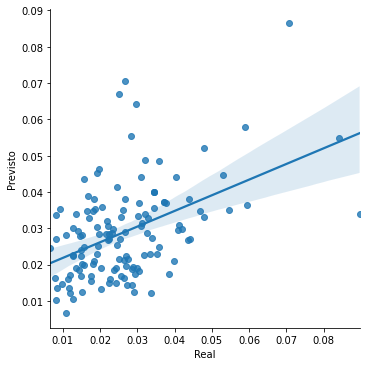

In [ ]:
df_corr_abs = pd.DataFrame ({'Real': ytest, 'Previsto': pred}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_abs);

In [ ]:
corr_abs_incidencia = covid_mob_idhm.corr().loc['last_available_confirmed_per_100k_inhabitants'].abs().sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[:12]
fig = go.Figure(data=go.Scatter(x=corr_abs_incidencia['last_available_confirmed_per_100k_inhabitants'], y=corr_abs_incidencia['indicador'], mode='markers')) 
fig.update_layout(title="Indicadores do IDHM e de mobilidade de maior correlação com incidência de COVID-19")
fig.show()

In [ ]:
corr_abs_incidencia

,indicador,last_available_confirmed_per_100k_inhabitants
2,T_FREQSUPER1517,0.473781
3,T_OCUPDESLOC_1,0.440972
4,T_FLSUPER,0.440188
5,EMP,0.434862
6,T_SUPER25M,0.368185
7,T_DES2529,0.359023
8,IDHM_R,0.357271
9,RDPC,0.348653
10,P_SUPER,0.346374
11,T_DENS,0.302797


In [ ]:
corr_abs_incidencia.drop(corr_abs_incidencia.loc[(corr_abs_incidencia['indicador'] == "last_available_death_rate")].index, inplace=True)
corr_abs_incidencia.drop(corr_abs_incidencia.loc[(corr_abs_incidencia['indicador'] == "last_available_confirmed_per_100k_inhabitants")].index, inplace=True)
corr_absl_incidencia = corr_abs_incidencia.indicador.to_list()
corr_absl_incidencia

['T_FREQSUPER1517',
 'T_OCUPDESLOC_1',
 'T_FLSUPER',
 'EMP',
 'T_SUPER25M',
 'T_DES2529',
 'IDHM_R',
 'RDPC',
 'P_SUPER',
 'T_DENS']

In [ ]:
#fazer a regressao linear de incidência